# Class Statistics

The process for the class statistics is relativly repatative. The comments for this code is more focused on putting the results into context.

Importing exported, transformed dataclasses

In [1]:
import json
import matplotlib.pyplot as plt
import operator
from collections import Counter

In [2]:
with open("data/entity_dump_cleaned_and_restructured.json", encoding = 'cp1252') as f:
    data = json.load(f)

In [3]:
# example of the data structure
for idx, (k, v) in enumerate(data.items()):
    if idx == 15: break
    print((k, v))
    print(' ')

('78A3ECC8-66C6-3EC3-A5C7-CD6A3D2FC6DE(type)', [[['U8B6Y4YM(type)', 'Namedgraph(custom)'], ['has_provider(custom)', 'KHI(source)']], [['78A3ECC8-66C6-3EC3-A5C7-CD6A3D2FC6DE(type)', 'E55_Type(cidoc-crm)'], {'Label': 'rechteckig'}, ['P2_has_type(cidoc-crm)', 'C57BB460-B736-3F52-8867-FFCF908C12B6(type)'], ['P67i_is_referred_to_by(cidoc-crm)', 'U8B6Y4YM(type)'], ['has_provider(custom)', 'KHI(source)']]])
 
('EAE7042F-9813-3A08-A641-29C38FDA23DB(actor)', [[['1JI28E47(actor)', 'Namedgraph(custom)'], ['has_provider(custom)', 'KHI(source)']], [['EAE7042F-9813-3A08-A641-29C38FDA23DB(actor)', 'E39_Actor(cidoc-crm)'], {'Label': "Museodell'OperadelDuomo"}, ['P67i_is_referred_to_by(cidoc-crm)', '1JI28E47(actor)'], ['P74_has_current_or_former_residence(cidoc-crm)', 'C4F5A52E-1878-3FE5-BCB0-B7E44903BA94(place)'], ['has_provider(custom)', 'KHI(source)']]])
 
('AB957EFD-FA4E-31E1-A0FC-D2A65C9A2567(type)', [[['1HBAHVGI(type)', 'Namedgraph(custom)'], ['has_provider(custom)', 'KHI(source)']], [['AB957EFD-

### Functions

This function replaces an id with the corresponding label. I.e. you want to see which artist or which place is ment by an certain id. This works for simple classes like actors, places and types but not for complex classes like works since they have multiple label tags.  

In [4]:
def exchange_id_with_value(id):
    value = data[id]
    for index in range(len(data[id])):
        for index_2 in range(len(data[id][index])):
            if type(data[id][index][index_2]) == dict:
                label = data[id][index][index_2]["Label"]
                break


    return label

## Artwork / Artist Relation

collecting all works from the data

In [5]:
work_dict = {}
for key in list(data.keys()):
    if key.__contains__("work"):
        work_dict[key] = data[key]

In [6]:
print(f'Number of identified artworks: {len(work_dict)}')

Number of identified artworks: 98948


looking for the artist of each artwork. When there is no artist, a placeholder will be created

In [7]:
works_and_artists = {}
for work in list(work_dict.keys()):
    
    work_as_key = None
    artist_id = "No Artist"
    profession_id = None
    
    
    for attribute in work_dict[work]:
        for index in range(len(attribute)):
            if type(attribute[index]) == list and attribute[index][0] == "PC14_carried_out_by(cidoc-crm)":
                work_as_key = work.split("(")[0]
                artist_id = attribute[index][1].split("(")[0]
            elif type(attribute[index]) == list and attribute[index][1] == "PC14_carried_out_by(cidoc-crm)":
                work_as_key = work.split("(")[0]
                artist_id = attribute[index][0].split("(")[0]

            if type(attribute[index]) == list and attribute[index][0] == "P14.1_in_the_role_of(cidoc-crm)":
                profession_id = exchange_id_with_value(attribute[index][1])
            elif type(attribute[index]) == list and attribute[index][0] == "P14.1_in_the_role_of(cidoc-crm)":
                profession_id = exchange_id_with_value(attribute[index][0])

    if work_as_key != None:
        works_and_artists[work_as_key] = (artist_id, profession_id)
    
      
    if work_as_key == None:
        work_as_key = work.split("(")[0]
        works_and_artists[work_as_key] = ["No Artist", None]

    #work_as_key = None
    


In [8]:
professions = set()
for element in works_and_artists:
    professions.add(works_and_artists[element][1])

In [9]:
print(professions)

{'Entwerferin', 'Objektkünstlerin', 'Lithographin', 'Kupferstecher&Zeichner', 'Radierer&Zeichner', 'Holzbildhauer&Stukkateur', 'Bildhauer&Architekt', 'Bildhauer&Tonbildner', 'Maler&Architekt&Bildhauer?', 'Kunsthandwerker', 'Kartograph&Zeichner', 'Zeichner&Radierer', 'Vergolder', 'Maler', 'Miniaturmaler', 'Steinmetz', 'Bühnenbildner', 'Schreiber', 'Elfenbeinschnitzer', 'Zeichner&Maler&Lithograph', 'Steinmetz?', 'Entwerfer&Stecher', 'Architekt&Bildhauer', 'Bildhauer&Zeichner', 'Intarsiator', 'Ebenist&Holzbildhauer', 'Bildhauer&Modelleur', 'Objektkünstler', 'Schnitzer', 'Aquatintaradierer', 'Modellbauer?', 'Zeichner&Illustrator', 'Bildnismalerin&Miniaturmalerin', 'Bildhauer', 'Stukkateur', 'Maler&Bildhauer', 'Maler&Radierer', 'Bildhauer&Bronzegießer', 'Kartenstecher', 'Inventor&Zeichner&Stecher', 'Architekt', 'Maler&Kupferstecher&Bildhauer', 'Dekorationsmaler', 'Schreiber?&Kopist', 'Lithograph&Entwerfer', 'Illustrator', 'Marmorsteinmetz', 'Goldschmied?', 'Maler&Zeichner&Bildhauer&Architek

Iterating over each artwork and counting the occourences of artist. Counting, how many works an artist has done.

In [10]:
# artist id as key -- list with number of artworks and the profession as values
artist_work_count = {}
artist_and_profession = {}
for work in list(works_and_artists.keys()):
    if works_and_artists[work][0] not in artist_work_count:
        artist_work_count[works_and_artists[work][0]] = [1, works_and_artists[work][1]]
        artist_and_profession[works_and_artists[work][0]] = works_and_artists[work][1]
    else:
        artist_work_count[works_and_artists[work][0]][0] += 1

In [11]:
print(artist_work_count)

{'No Artist': [45312, None], '07600210': [5, 'Bildhauer'], '00086500': [70, 'Bildhauer'], '07930088': [32, 'Bildhauer'], '02552920': [327, None], '20190014': [5, 'Bildhauer'], '07650116': [17, 'Miniaturmaler'], '07650115': [11, 'Miniaturmaler'], '11007735': [7, 'Bildhauer'], '20110260': [86, 'Zeichner'], '02552739': [87, 'Miniaturmaler'], '20033293': [3, 'Miniaturmaler'], '02552100': [25, 'Entwerfer'], '02552990': [696, 'Maler'], '20110017': [9, 'Maler'], '20033291': [1, 'Stukkateur'], '00264500': [35, 'Maler'], '00429500': [54, 'Maler'], '02020057': [267, 'Zeichner'], '07600374': [2, 'Bildhauer'], '00154200': [6, 'Buchmaler'], '00257100': [56, 'Bildhauer'], '02553162': [401, 'Maler'], '07603472': [67, 'Maler'], '07990036': [1, 'Steinmetz'], '07500304': [2, 'Miniaturmaler'], '02552994': [196, None], '10081212': [179, 'Entwerfer'], '02553023': [25, 'Bildhauer'], '10081616': [13, None], '20033255': [8, 'Miniaturmaler'], '10103229': [158, 'Bildhauer'], '07500117': [19, 'Bildhauer'], '0750

In [12]:
print(f'Artworks with artist: {len(work_dict) - artist_work_count["No Artist"][0]}')

Artworks with artist: 53636


In [13]:
print(f'The total number of identified artists is: {len(artist_work_count)}')

The total number of identified artists is: 6330


Iterating over the artists and counting each artist with a certain amount of artworks. How many artists have made exactly one artwork, how many have made two and so on

In [14]:
works_per_artist = [artist_work_count[artist][0] for artist in list(artist_work_count.keys()) if artist != 'No Artist']
X = [] # size of artist portfolio
Y = [] # frequency of each size (how many artists have that portfolio size)

sizeDist = Counter(sorted(works_per_artist))
for s,f in sizeDist.items():
    X.append(s)
    Y.append(f)
    
print(X)
print(Y)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 79, 80, 82, 84, 85, 86, 87, 90, 92, 93, 95, 96, 98, 99, 102, 103, 106, 107, 108, 112, 113, 119, 120, 127, 128, 132, 135, 136, 137, 141, 142, 143, 144, 149, 151, 158, 160, 163, 164, 167, 168, 170, 172, 179, 180, 185, 186, 190, 192, 195, 196, 204, 212, 213, 218, 222, 224, 225, 226, 231, 243, 254, 256, 258, 267, 271, 280, 327, 331, 343, 350, 359, 363, 366, 367, 401, 481, 506, 530, 603, 696, 782]
[2953, 914, 444, 328, 236, 163, 125, 132, 85, 61, 72, 56, 50, 39, 39, 36, 38, 28, 26, 23, 21, 17, 16, 21, 18, 12, 3, 14, 17, 14, 10, 15, 4, 7, 8, 7, 4, 11, 4, 6, 9, 7, 3, 5, 2, 5, 5, 2, 4, 3, 4, 6, 5, 7, 4, 5, 5, 2, 3, 6, 2, 4, 4, 6, 5, 2, 5, 6, 1, 4, 1, 3, 4, 1, 2, 3, 2, 1, 4, 5, 3, 3, 3, 2, 1, 1, 2, 2, 2, 1, 

ploting the data

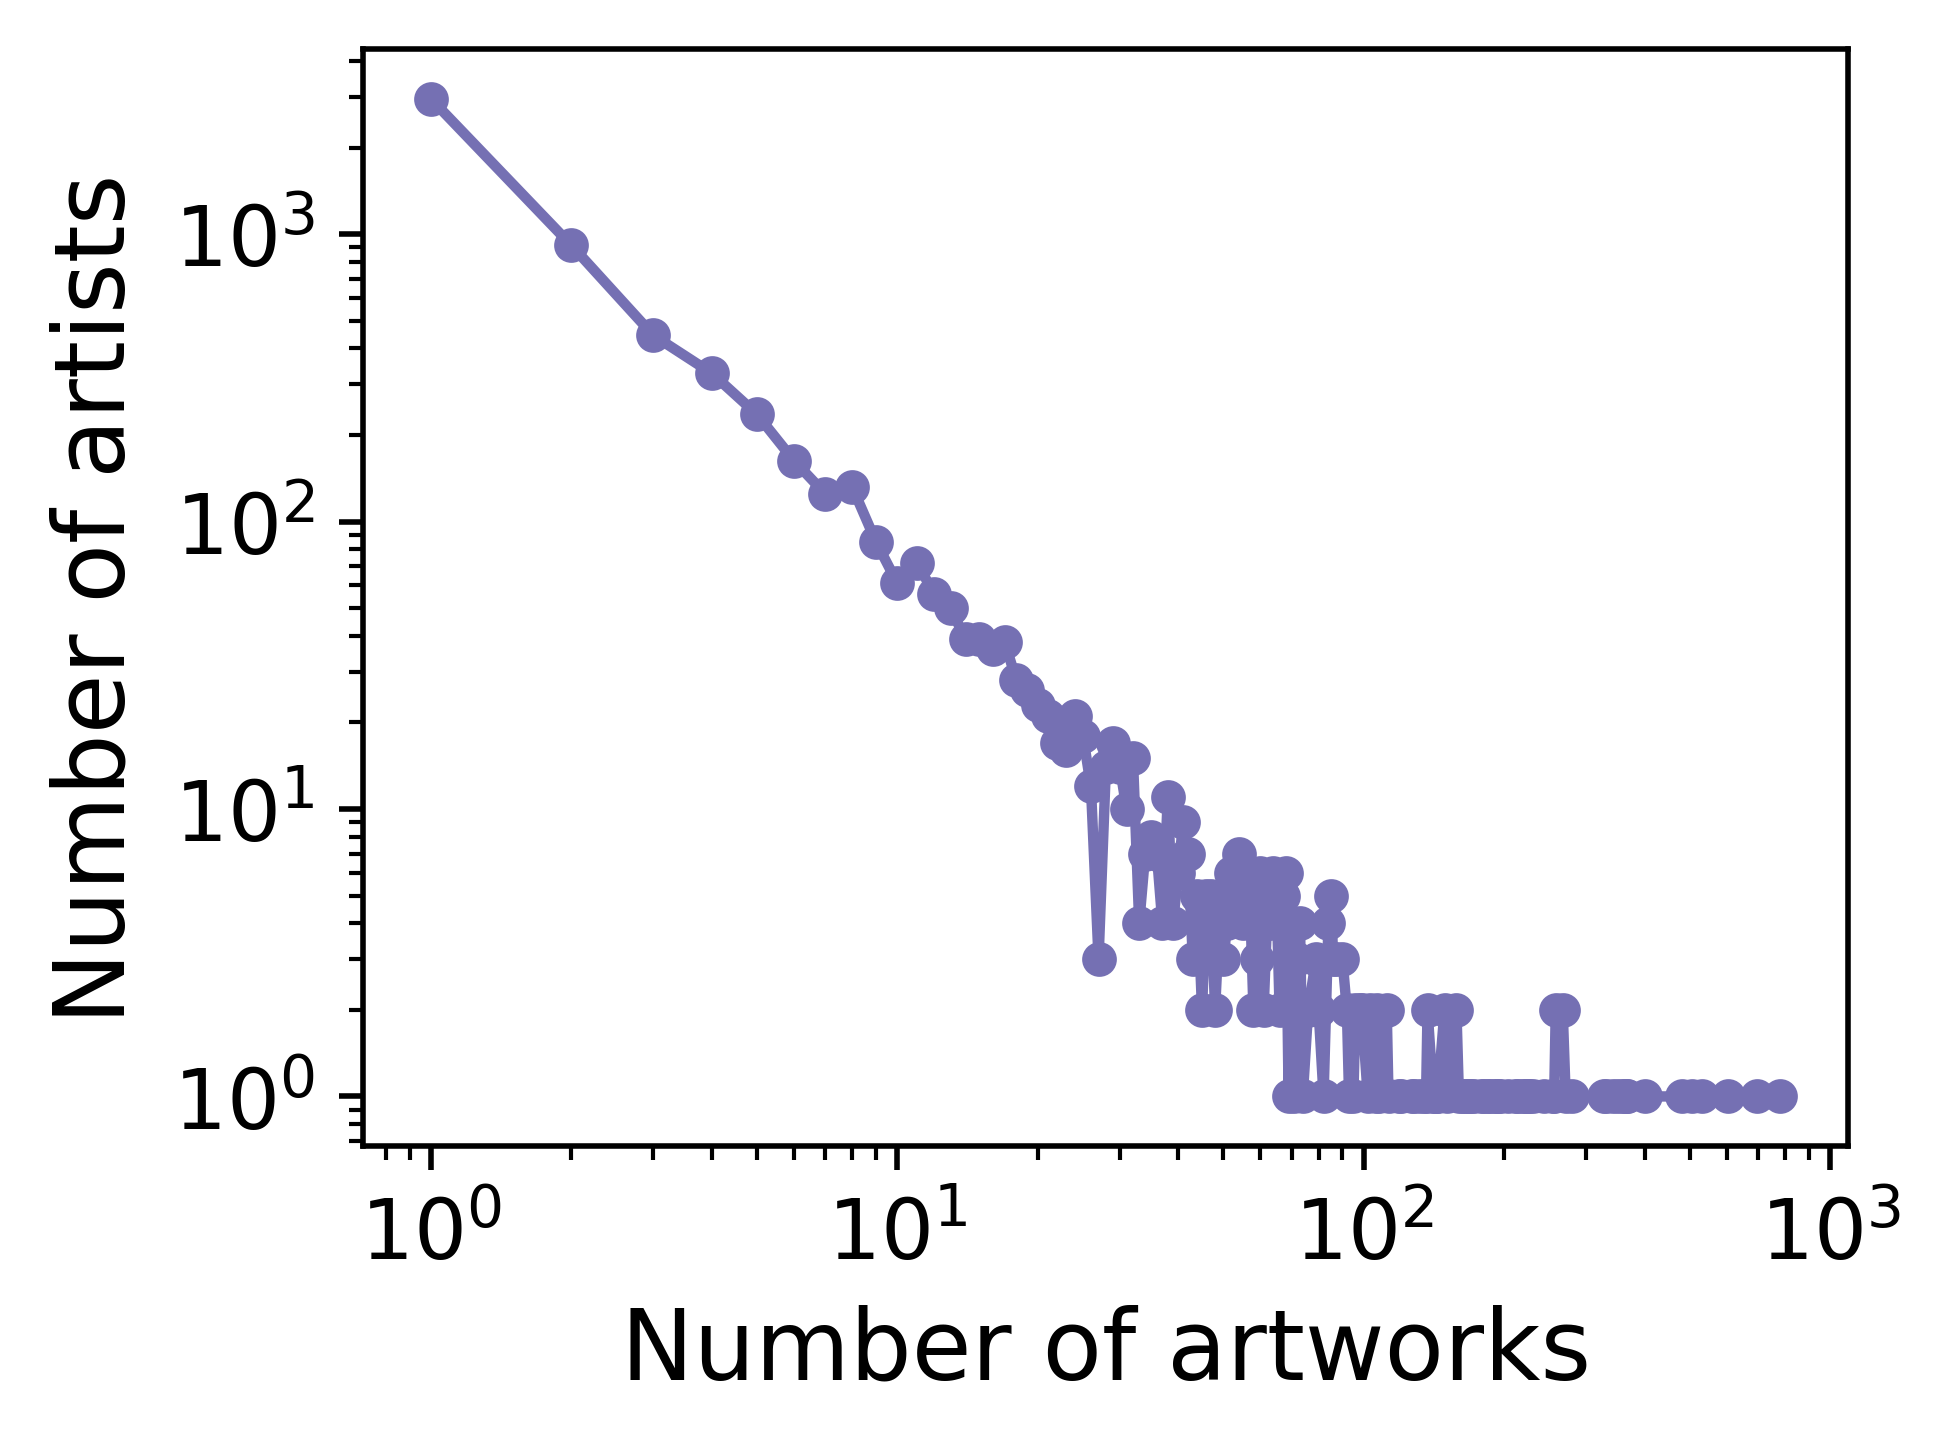

In [15]:
# plotting distributions of works per artist (number of artists with a number of works)
# figure environment
fig, ax = plt.subplots(figsize=(4,3), dpi=500)

#plotting
ax.loglog(X, Y, color='#7570b3', marker='o',
            linewidth=1.5, linestyle='-', ms=4, label='Events')


# axis set-up
ax.set_xlabel('Number of artworks', fontsize=14)
ax.set_ylabel('Number of artists', fontsize=14)

# set axis format
ax.tick_params(axis='both', which='major', labelsize=12)

#Set legend
#ax.legend(loc='upper right', frameon=False, numpoints=1, fontsize=14)

#plt.savefig('filename', format='pdf', dpi=500)
plt.tight_layout()
plt.savefig(f'figures/dist_artist_artwork.png', format='png', dpi=500)
plt.savefig(f'figures/dist_artist_artwork.pdf', format='pdf', dpi=500)

plt.show()

In [145]:
# number of works per artists with most works
most_works = [element[0] for element in list(artist_work_count.values())]
most_works.sort(reverse=True)
most_works = most_works[1:16] # excluding the first element 'No Artist'
print(most_works)

[782, 696, 603, 530, 506, 481, 401, 367, 366, 363, 359, 350, 343, 331, 327]


In [146]:
top_artists = [element for element in artist_work_count if artist_work_count[element][0] in most_works]
top_artists = [element + "(actor)" for element in top_artists]
top_artists = [exchange_id_with_value(element) for element in top_artists]

In [147]:
print("Artists with most artworks")
for i,element in enumerate(top_artists):
    #print("{}".format(element))
    print(f'{element} -- {most_works[i]}')

Artists with most artworks
Rosa,Salvator -- 782
Tiepolo,GiovanniBattista -- 696
Raphaello -- 603
TizianoVecelio -- 530
Barocci,Federico -- 506
Bellini,Giovanni(1430) -- 481
Carracci,Annibale -- 401
Fattori,Giovanni -- 367
Veronese -- 366
Bazzoli,Giuseppe -- 363
Cortese,Guglielmo -- 359
Ramboux,JohannAntonAlban -- 350
Bassano,? -- 343
Nono,Luigi -- 331
Pozzi,GiovanniBattista(1561) -- 327


## Artwork / Location Relation

collecting all works from the data

In [16]:
work_dict = {}
for key in list(data.keys()):
    if key.__contains__("work"):
        work_dict[key] = data[key]

In [17]:
works_and_places = {}
for work in list(work_dict.keys()):
    
    work_as_key = None
    place_id = "No Place"
    
    for attribute in work_dict[work]:
        for index in range(len(attribute)):
            if type(attribute[index]) == list and attribute[index][0] == "P55_has_current_location(cidoc-crm)":
                work_as_key = work.split("(")[0]
                place_id = attribute[index][1].split("(")[0]
            elif type(attribute[index]) == list and attribute[index][1] == "P55_has_current_location(cidoc-crm)":
                work_as_key = work.split("(")[0]
                place_id = attribute[index][0].split("(")[0]
            """
            if type(attribute[index]) == list and attribute[index][0] == "P14.1_in_the_role_of(cidoc-crm)":
                profession_id = exchange_id_with_value(attribute[index][1])
            elif type(attribute[index]) == list and attribute[index][0] == "P14.1_in_the_role_of(cidoc-crm)":
                profession_id = exchange_id_with_value(attribute[index][0])
                """

    if work_as_key != None:
        works_and_places[work_as_key] = place_id
    
      
    if work_as_key == None:
        work_as_key = work.split("(")[0]
        works_and_places[work_as_key] = "No Place"

    #work_as_key = None

In [18]:
place_work_count = {}
for work in list(works_and_places.keys()):
    if works_and_places[work] not in place_work_count:
        place_work_count[works_and_places[work]] = 1
    else:
        place_work_count[works_and_places[work]] += 1

In [19]:
print(f'The total number of unique places with artworks is: {len(place_work_count)}')

The total number of unique places with artworks is: 5310


In [20]:
works_per_place = [place_work_count[place] for place in list(place_work_count.keys()) if place != 'No Place']
X = [] # size of place portfolio
Y = [] # frequency of each size (how many places have that portfolio size)

sizeDist = Counter(sorted(works_per_place))
for s,f in sizeDist.items():
    X.append(s)
    Y.append(f)
    
print(X)
print(Y)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 47, 48, 49, 50, 51, 52, 56, 58, 61, 66, 67, 70, 71, 75, 82, 83, 84, 86, 87, 88, 89, 92, 99, 100, 107, 113, 114, 117, 119, 120, 131, 137, 148, 149, 198, 205, 264, 278, 312, 362, 580, 753, 2224]
[3091, 822, 383, 241, 139, 89, 82, 62, 46, 40, 25, 25, 17, 11, 23, 14, 19, 18, 9, 8, 11, 9, 5, 3, 6, 7, 4, 3, 8, 7, 3, 2, 4, 2, 2, 1, 4, 2, 1, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


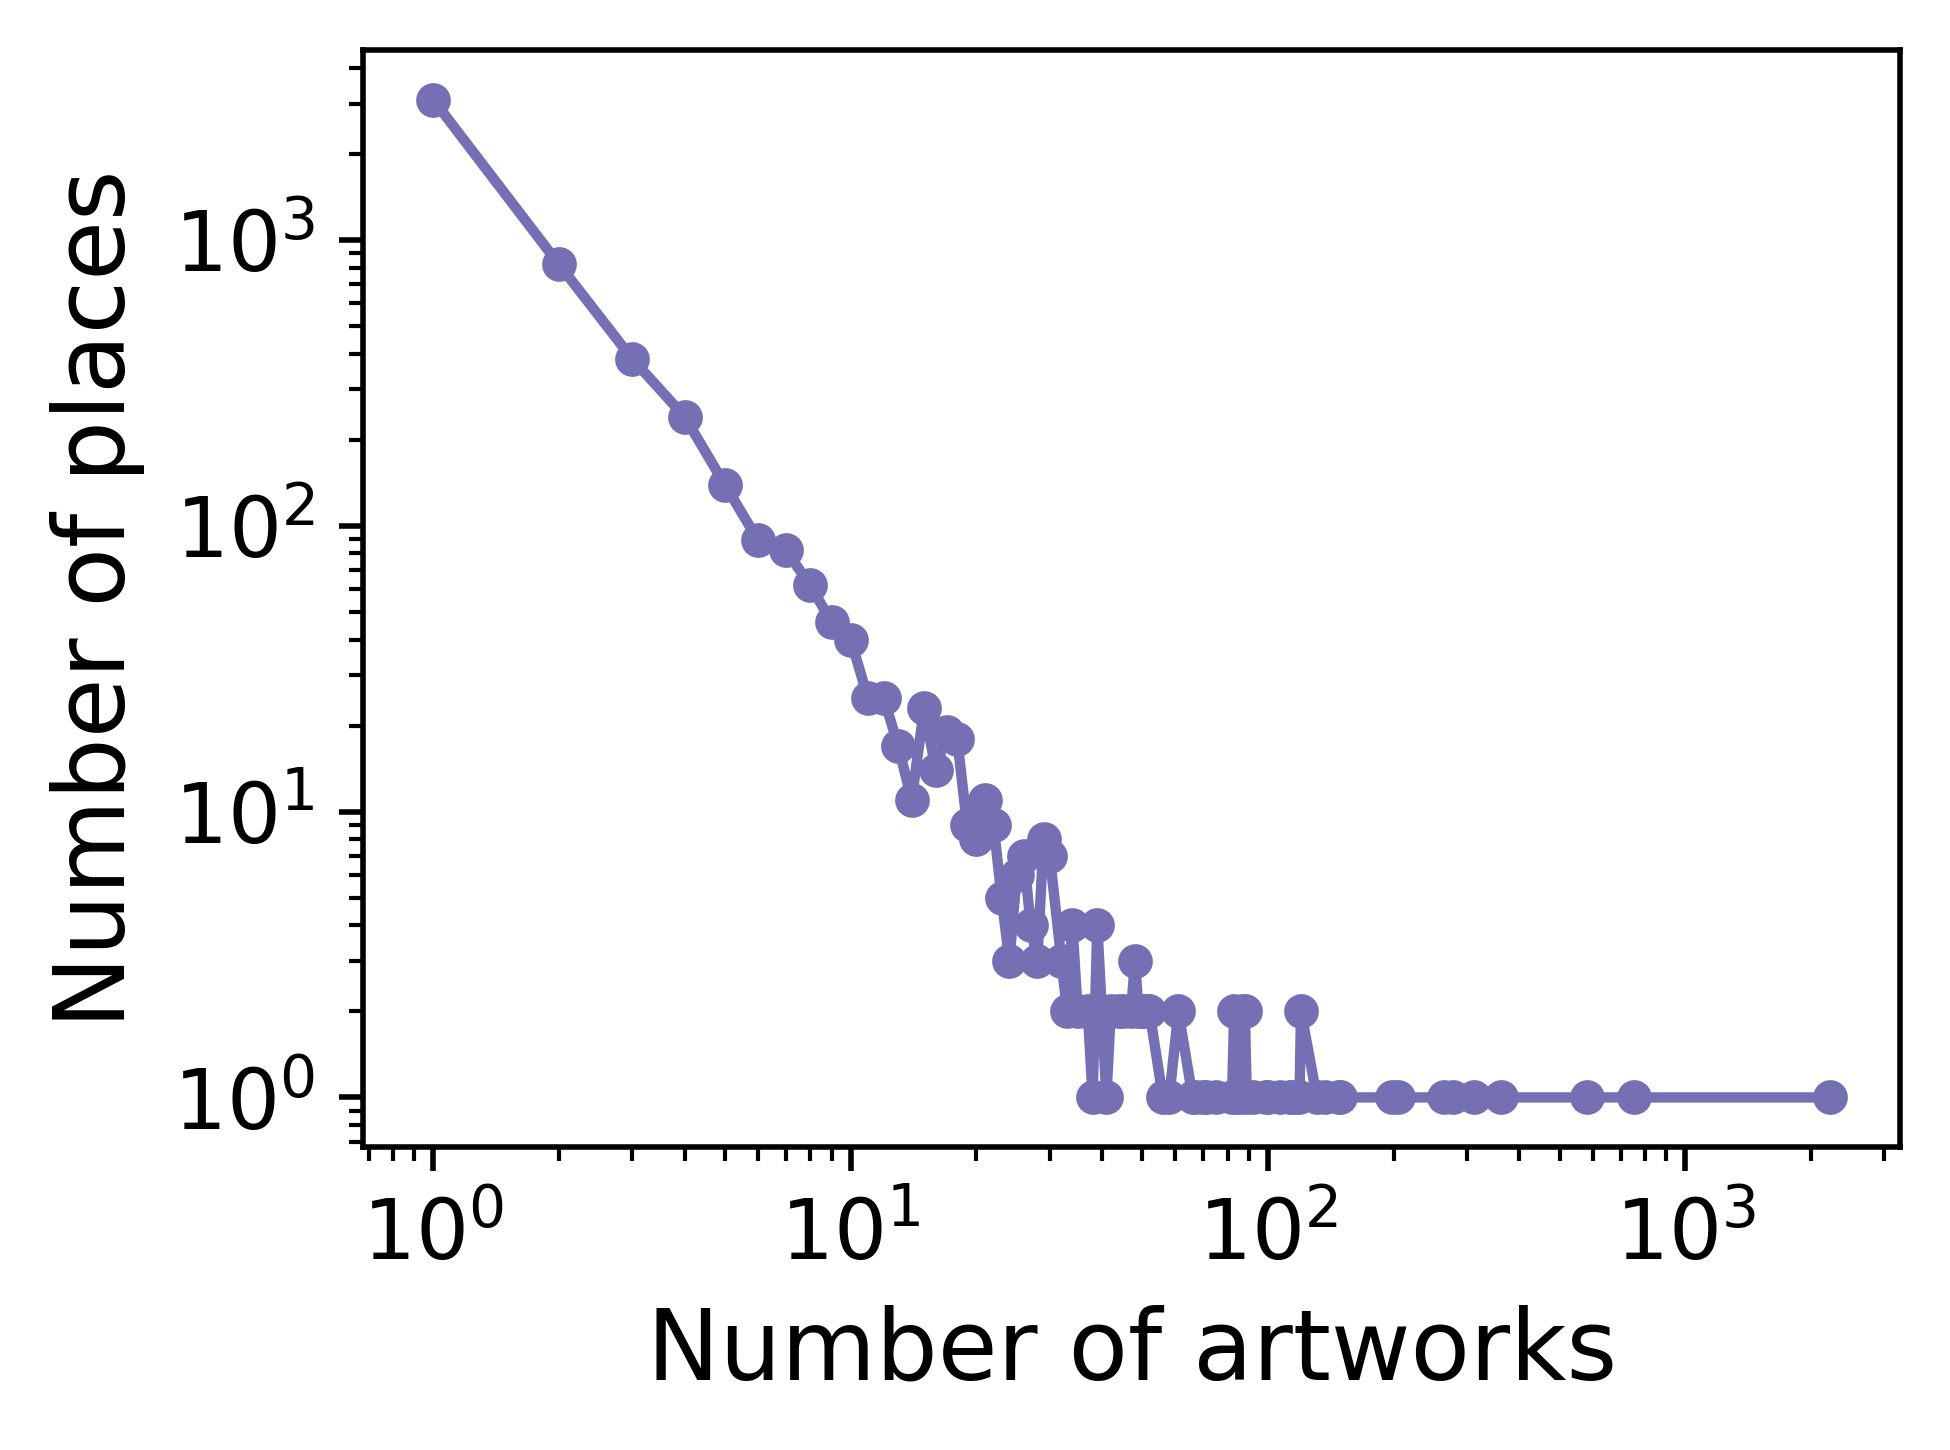

In [21]:
# plotting distributions of works per place (numner of places with a number of works)
# figure environment
fig, ax = plt.subplots(figsize=(4,3), dpi=500)

#plotting
ax.loglog(X, Y, color='#7570b3', marker='o',
            linewidth=1.5, linestyle='-', ms=4, label='Events')


# axis set-up
ax.set_xlabel('Number of artworks', fontsize=14)
ax.set_ylabel('Number of places', fontsize=14)

# set axis format
ax.tick_params(axis='both', which='major', labelsize=12)

#Set legend
#ax.legend(loc='upper right', frameon=False, numpoints=1, fontsize=14)

#plt.savefig('filename', format='pdf', dpi=500)
plt.tight_layout()
plt.savefig(f'figures/dist_place_artwork.png', format='png', dpi=500)
plt.savefig(f'figures/dist_place_artwork.pdf', format='pdf', dpi=500)

plt.show()

In [86]:
most_works = [element for element in list(place_work_count.values())]
most_works.sort(reverse=True)
most_works = most_works[1:16]

In [87]:
top_places = [element for element in place_work_count if place_work_count[element] in most_works]
top_places = [element + "(place)" for element in top_places]
top_places = [exchange_id_with_value(element) for element in top_places]

In [88]:
print("Places with most artworks")
for i,element in enumerate(top_places):
    #print("{}".format(element))
    print(f'{element} -- {most_works[i]}')

Places with most artworks
Genua -- 2224
SantaMariaAssunta -- 753
Volterra -- 580
Florenz -- 362
SanFrancesco -- 312
Rom -- 278
SanDomenico -- 264
Siena -- 205
SantaCroce -- 198
Sant'Agostino -- 149
Venedig -- 148
Pistoia -- 137
Assisi -- 131
Perugia -- 120
Montepulciano -- 120


## Person / Location Relation

In [22]:
person_dict = {}
for key in list(data.keys()):
    if key.__contains__("actor"):
        person_dict[key] = data[key]

In [23]:
print(f'Total number of identified persons: {len(person_dict)}')

Total number of identified persons: 16011


In [24]:
persons_and_places = {}

for person in list(person_dict.keys()):
    
    person_as_key = None
    
    
    for attribute in person_dict[person]:
        for index in range(len(attribute)):
            if type(attribute[index]) == list and attribute[index][0] == "P74_has_current_or_former_residence(cidoc-crm)":
                person_as_key = person.split("(")[0]
                place_id = attribute[index][1].split("(")[0]
            elif type(attribute[index]) == list and attribute[index][1] == "P74_has_current_or_former_residence(cidoc-crm)":
                person_as_key = person.split("(")[0]
                place_id = attribute[index][0].split("(")[0]
            """
            if type(attribute[index]) == list and attribute[index][0] == "P14.1_in_the_role_of(cidoc-crm)":
                profession_id = exchange_id_with_value(attribute[index][1])
            elif type(attribute[index]) == list and attribute[index][0] == "P14.1_in_the_role_of(cidoc-crm)":
                profession_id = exchange_id_with_value(attribute[index][0])
                """

    if person_as_key != None:
        persons_and_places[person_as_key] = place_id
    
      
    if person_as_key == None:
        person_as_key = person.split("(")[0]
        persons_and_places[person_as_key] = "No Place"

    
    


In [25]:
place_person_count = {}
for person in list(persons_and_places.keys()):
    if persons_and_places[person] not in place_person_count:
        place_person_count[persons_and_places[person]] = 1
    else:
        place_person_count[persons_and_places[person]] += 1

In [26]:
print(f'Total number of unique places with persons: {len(place_person_count)}')

Total number of unique places with persons: 903


In [27]:
persons_per_place = [place_person_count[place] for place in list(place_person_count.keys()) if place != 'No Place']
X = [] # number of artists resident in a place
Y = [] # how many places have that many people resident there

sizeDist = Counter(sorted(persons_per_place))
for s,f in sizeDist.items():
    X.append(s)
    Y.append(f)
    
print(X)
print(Y)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 25, 29, 33, 35, 38, 46, 49, 50, 52, 53, 55, 57, 64, 71, 75, 118, 135, 149, 162, 184, 264, 284, 441, 647]
[604, 126, 44, 32, 15, 9, 4, 6, 4, 5, 3, 3, 3, 5, 1, 3, 4, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


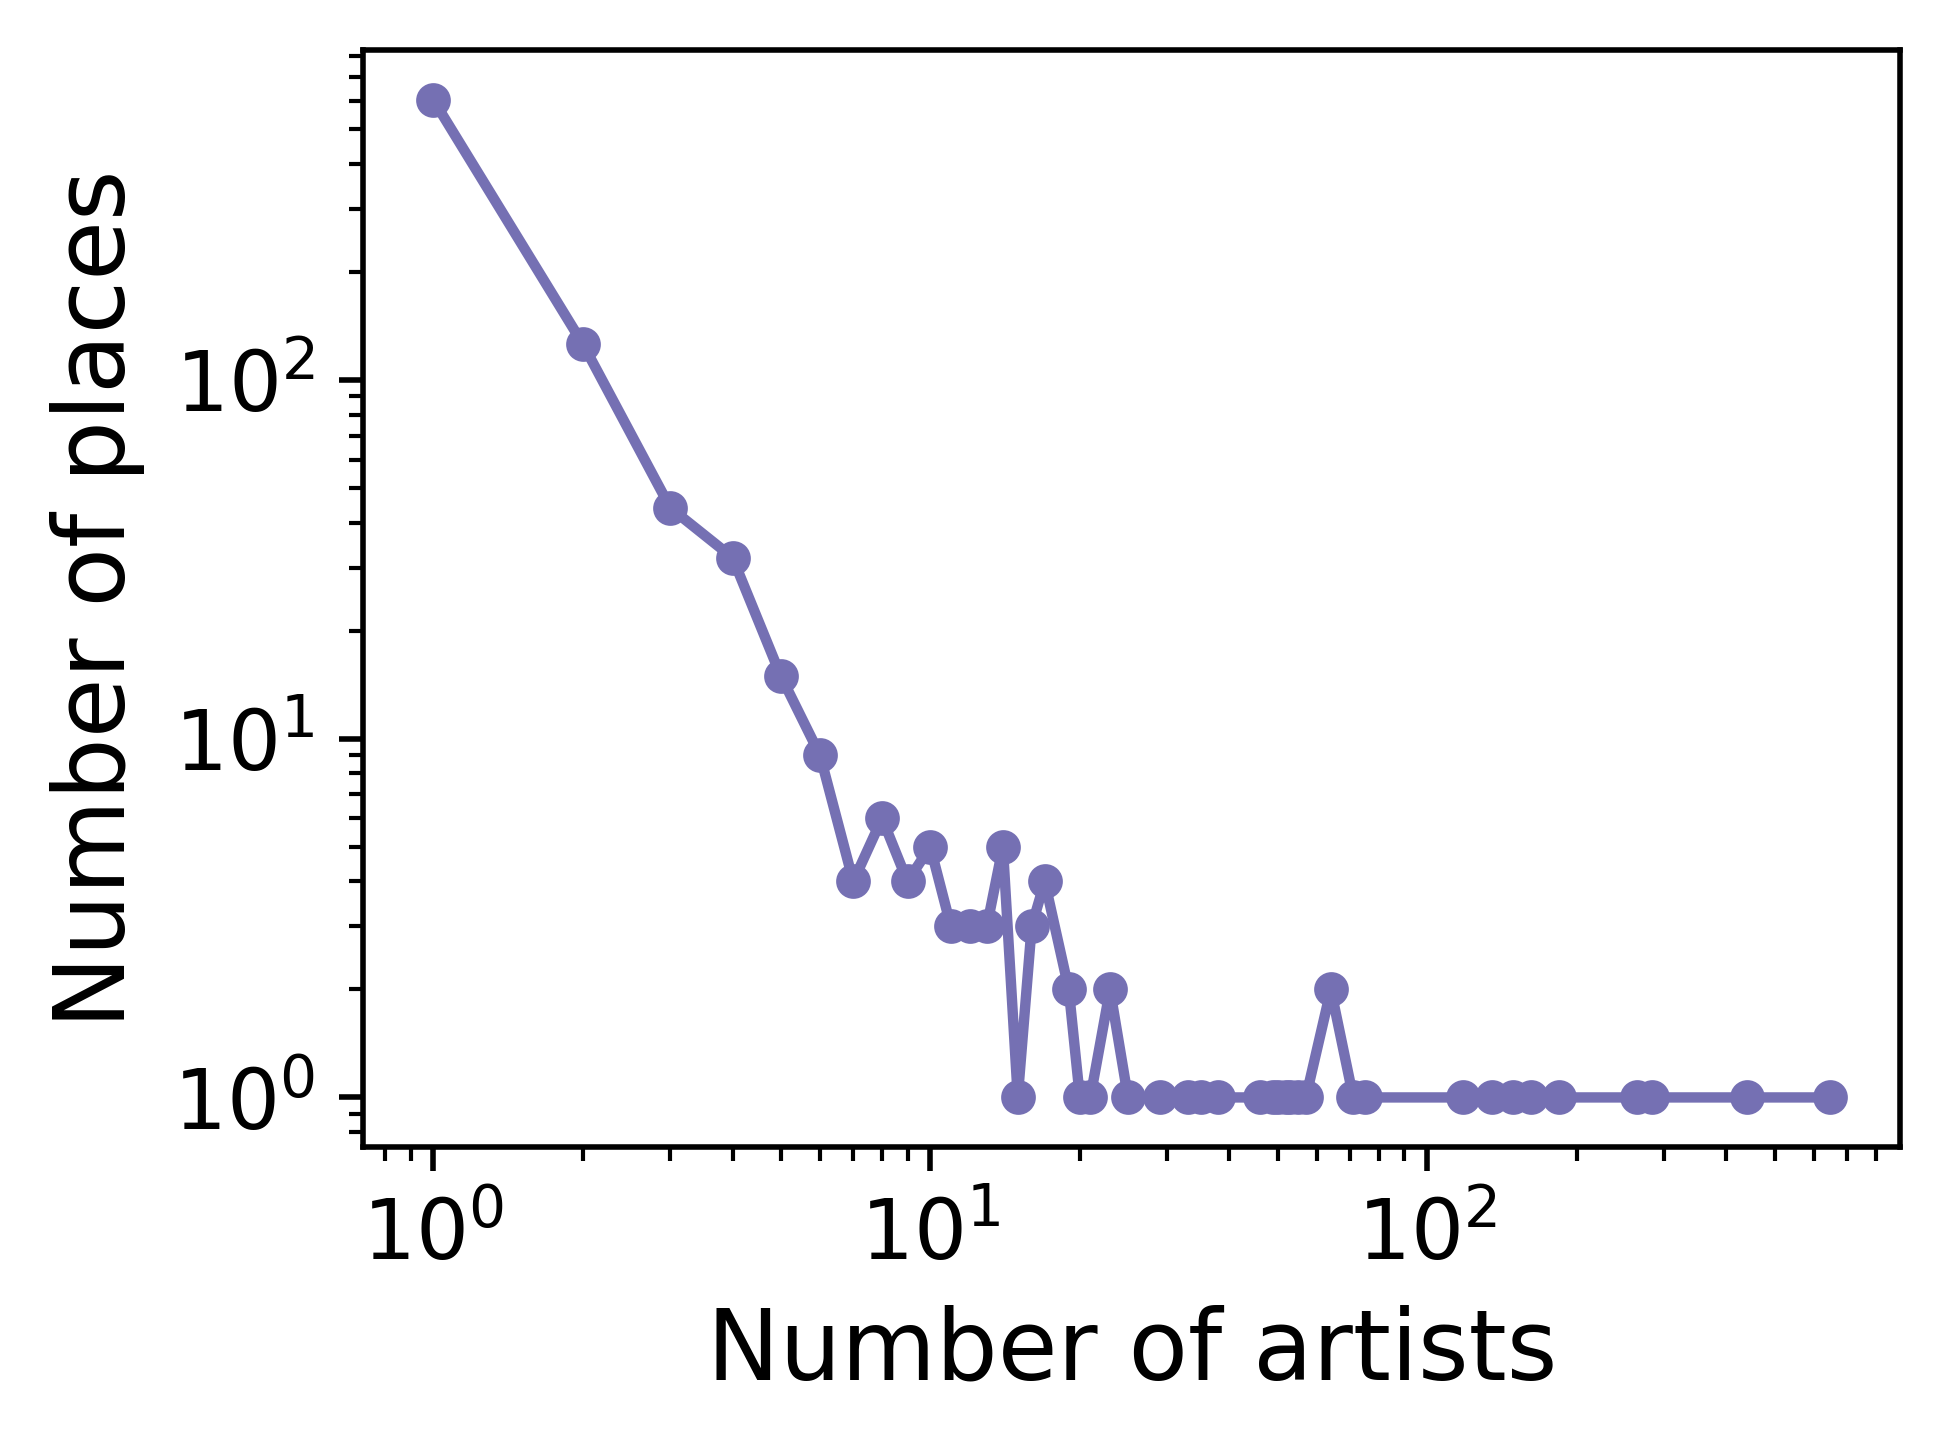

In [28]:
# plotting distributions of works per place (numner of places with a number of works)
# figure environment
fig, ax = plt.subplots(figsize=(4,3), dpi=500)

#plotting
ax.loglog(X, Y, color='#7570b3', marker='o',
            linewidth=1.5, linestyle='-', ms=4, label='Events')


# axis set-up
ax.set_xlabel('Number of artists', fontsize=14)
ax.set_ylabel('Number of places', fontsize=14)

# set axis format
ax.tick_params(axis='both', which='major', labelsize=12)

#Set legend
#ax.legend(loc='upper right', frameon=False, numpoints=1, fontsize=14)

#plt.savefig('filename', format='pdf', dpi=500)
plt.tight_layout()
plt.savefig(f'figures/dist_place_artist.png', format='png', dpi=500)
plt.savefig(f'figures/dist_place_artist.pdf', format='pdf', dpi=500)

plt.show()

In [121]:
most_persons = [element for element in list(place_person_count.values())]
most_persons.sort(reverse=True)
most_persons = most_persons[1:16]

In [122]:
top_places = [element for element in place_person_count if place_person_count[element] in most_persons]
top_places = [element + "(place)" for element in top_places]
top_places = [exchange_id_with_value(element) for element in top_places]

In [123]:
print("Places with most Artists")
for i,element in enumerate(top_places):
    #print("{}".format(element))
    print(f'{element} -- {most_persons[i]}')

Places with most Artists
Florenz -- 647
Rom -- 441
Venedig -- 284
Mailand -- 264
Wien -- 184
London -- 162
Berlin -- 149
Paris -- 135
NewYork -- 118
Ortunbekannt -- 75
Turin -- 71
München -- 64
Neapel -- 64
Bergamo -- 57
Genua -- 55


## Photographer / Artwork Relation

### Preprocessing

In this part of the code all the different classes will be collected from the data and stored in separate dictionaries of data.

In [38]:
work_dict = {}
for key in list(data.keys()):
    if key.__contains__("work"):
        work_dict[key] = data[key]

In [39]:
actor_dict = {}
for key in list(data.keys()):
    if key.__contains__("actor"):
        actor_dict[key] = data[key]

In [40]:
type_dict = {}
for key in list(data.keys()):
    if key.__contains__("type"):
        type_dict[key] = data[key]

In [41]:
photo_dict = {}
for key in list(data.keys()):
    if key.__contains__("photo"):
        photo_dict[key] = data[key]

To see if the photo carries a motive, we have to look at the "P128_carries(cidoc-crm)" relation of each photo. Propably not every photo without this relation has no motive, but it may not be present in the dataset.

In [42]:
photos_with_works = {}
for counter, photo in enumerate(photo_dict):
    for attribute in photo_dict[photo]:
        for index in range(len(attribute)):
            if type(attribute[index]) == list and "P128_carries(cidoc-crm)" in attribute[index]:
                photos_with_works[photo] = photo_dict[photo]

In [43]:
print("Number of photos in the dataset: {}".format(len(photo_dict)))

print("Number of photos with a relation to an artwork from the dataset: {}".format(len(photos_with_works)))

Number of photos in the dataset: 45192
Number of photos with a relation to an artwork from the dataset: 33028


The following code collects all photographers in the dataset and counts the amount of photos of them.

In [36]:
photographer_dict = {}

for counter, photo in enumerate(photo_dict):
    for attribute in photo_dict[photo]:
        for index in range(len(attribute)):
            """
            if type(attribute[index]) == list and "P128_carries(cidoc-crm)" in attribute[index]:
                work_on_photo = [ element.split("(")[1].replace(")", "") for element in attribute[index] if element.__contains__("visual_item")][0]
            """
            if type(attribute[index]) == list and "P14_carried_out_by(cidoc-crm)" in attribute[index]:
                photographer = exchange_id_with_value([element for element in attribute[index] if element.__contains__("actor")][0])

    if photographer not in photographer_dict:
        photographer_dict[photographer] = 1
    else:
        photographer_dict[photographer] += 1

NameError: name 'photographer' is not defined

In [39]:
print("Number of photographers regardless of the relation of the photos to an object: {}".format(len(photographer_dict)))

Number of photographers regardless of the relation of the photos to an object: 187


In [43]:
print("Number of photos {} has taken: {}".format("Bazzechi,Ivo", photographer_dict["Bazzechi,Ivo"]))
print("Number of photos {} has taken: {}".format("Fiorucci,Carlo", photographer_dict["Fiorucci,Carlo"]))


Number of photos Bazzechi,Ivo has taken: 3196
Number of photos Fiorucci,Carlo has taken: 1654


The following code does the same as the one before. But this time it is focused on the photos with a motive represented in the dataset. Because of that every motive will be counted seperatly.

In [37]:
photographer_dict = {}

for counter, photo in enumerate(photos_with_works):
    for attribute in photo_dict[photo]:
        for index in range(len(attribute)):
            if type(attribute[index]) == list and "P128_carries(cidoc-crm)" in attribute[index]:
                work_on_photo = [ element.split("(")[1].replace(")", "") for element in attribute[index] if element.__contains__("visual_item")][0]
            if type(attribute[index]) == list and "P14_carried_out_by(cidoc-crm)" in attribute[index]:
                photographer = exchange_id_with_value([element for element in attribute[index] if element.__contains__("actor")][0])

    if photographer not in photographer_dict:
        photographer_dict[photographer] = {work_on_photo: 1}
    elif work_on_photo not in photographer_dict[photographer]:
        photographer_dict[photographer][work_on_photo] = 1
    else:
        photographer_dict[photographer][work_on_photo] += 1

NameError: name 'photographer' is not defined

The following code reveals an unexpected result. To compare both numbers for the photographers I looked on the photos of Ivo Bazzechi. In total there are 3196 photos which are related to this photographer.  
As we know the numbers of photos with a relation to a motive is less then the total number of pictures. But when we look on this photographer and only on his photos with such a relation the number of photos climbes to 3227. The first assumption is, that probably there is a fault in the code.

In [45]:
print("Number of photographers with photos with motive relation: {}".format(len(photographer_dict)))
print("Number of motives {} has photographed: {}".format("Bazzechi,Ivo", len(photographer_dict["Bazzechi,Ivo"])))


total_number_of_photos_with_motive = 0
for element in photographer_dict["Bazzechi,Ivo"]:
    total_number_of_photos_with_motive += photographer_dict["Bazzechi,Ivo"][element]

print("Number of photos {} has taken in total: {}".format("Bazzechi,Ivo", total_number_of_photos_with_motive))

# print(photographer_dict["Bazzechi,Ivo"])

Number of photographers with photos with motive relation: 68
Number of motives Bazzechi,Ivo has photographed: 1525
Number of photos Bazzechi,Ivo has taken in total: 3227


The following code lists five artists of the "photographers with photos with motive relation" dictionary. It lists their ten most photographed artworks and the total number of artworks photographed and also the total number of photos taken (With the same issue as above by "Fiorucci,Carlo").

In [46]:
for element in list(photographer_dict.keys())[:5]:
    photographer_artwork_values = sorted(photographer_dict[element].items(), key=operator.itemgetter(1), reverse=True)
    photographer_artwork_values = dict(photographer_artwork_values)

    print("TOP 10 artworks photographed by {}\n".format(element))
    for top_position in list(photographer_artwork_values.keys())[:10]:
        print("{} times:\t{}".format(photographer_artwork_values[top_position], top_position))

    total_number_of_photos_with_motive = 0
    for photo in photographer_dict[element]:
        total_number_of_photos_with_motive += photographer_dict[element][photo]

    print("\nNumber of photos {} has taken in total: {}".format(element, total_number_of_photos_with_motive))
    
    print("\nTotal number of artworks photographed: {}\n\n".format(len(photographer_dict[element])))

TOP 10 artworks photographed by Sigismondi,Roberto

45 times:	07705627
39 times:	07705270
38 times:	07705617
36 times:	07874132
32 times:	07963237
29 times:	70004783
27 times:	07962386
26 times:	07857019
25 times:	70004833
24 times:	07874062

Number of photos Sigismondi,Roberto has taken in total: 9263

Total number of artworks photographed: 4049


TOP 10 artworks photographed by Artini,Luigi

60 times:	07930037%2CT%2C001%2CT
57 times:	07580149
56 times:	07501836%2CT%2C001%2CT
55 times:	07873109
50 times:	07501836%2CT%2C001%2CT%2C002%2CT%2C001
49 times:	07873106
48 times:	70001475
44 times:	07930039%2CT%2C001
44 times:	07502889
43 times:	07930039%2CT%2C002

Number of photos Artini,Luigi has taken in total: 6771

Total number of artworks photographed: 2834


TOP 10 artworks photographed by Brogi

10 times:	07580181
8 times:	07599766
8 times:	07605036
8 times:	07580319
6 times:	07600337
6 times:	07580166
6 times:	07580216
5 times:	07600318
5 times:	07858369
5 times:	07580277

Number of p

The following code asks the similar questions as above, but from the perspective of the artworks.

In [13]:
work_photographer_relation_dict = {}

for photographer in photographer_dict:
    for work in photographer_dict[photographer]:
        if work not in work_photographer_relation_dict:
            work_photographer_relation_dict[work] = {photographer: photographer_dict[photographer][work]}
        else:
            work_photographer_relation_dict[work][photographer] = photographer_dict[photographer][work]

Question: How many artworks are photographed by multiple photographers?

In [14]:
counter = 0
for work in work_photographer_relation_dict:
    if len(work_photographer_relation_dict[work]) > 1:
        counter += 1

print("Answer: {} artworks were photographed by multiple photographers".format(counter))

Answer: 688 artworks were photographed by multiple photographers


Question: Which artwork was photographed by the most photographers?

In [15]:
#Answer Part 1

counter = 0
for work in work_photographer_relation_dict:
    if ((len(work_photographer_relation_dict[work]) > 1) and (len(work_photographer_relation_dict[work]) > counter)):
        counter = len(work_photographer_relation_dict[work])

print("The artworks with the most photographers were photographed by {} diffrent persons".format(counter))


The artworks with the most photographers were photographed by 8 diffrent persons


In [16]:
#Answer Part 2

works = []
for work in work_photographer_relation_dict:
    if len(work_photographer_relation_dict[work]) == 8:
        works.append(work)

print("Answer: {} artworks were photographed by {} photographers. These are the IDs: {}".format(len(works), counter, works))

Answer: 2 artworks were photographed by 8 photographers. These are the IDs: ['07930087', '07501527']


In [17]:
print(work_photographer_relation_dict[works[0]])

{'Sigismondi,Roberto': 6, 'Artini,Luigi': 2, 'Brogi': 1, 'Lotz-Bauer,Hilde': 1, 'Polesel,Mario': 2, 'Schmidt,HansWerner': 1, 'Bazzechi,Ivo': 2, 'Trachtenberg,Marvin': 1}


In [18]:
quantity_work_photographer_dict = {}

for work in work_photographer_relation_dict:
    if len(work_photographer_relation_dict[work]) not in quantity_work_photographer_dict:
        quantity_work_photographer_dict[len(work_photographer_relation_dict[work])] = 1
    else:
        quantity_work_photographer_dict[len(work_photographer_relation_dict[work])] += 1

In [19]:
sorted_key_list = list(quantity_work_photographer_dict.keys())
sorted_key_list.sort(reverse=True)
# print(sorted_key_list)

for key in sorted_key_list:
    print("Number of Artworks which are photographed by {} photographers: {}".format(key, quantity_work_photographer_dict[key]))

Number of Artworks which are photographed by 8 photographers: 2
Number of Artworks which are photographed by 7 photographers: 1
Number of Artworks which are photographed by 6 photographers: 2
Number of Artworks which are photographed by 5 photographers: 15
Number of Artworks which are photographed by 4 photographers: 37
Number of Artworks which are photographed by 3 photographers: 95
Number of Artworks which are photographed by 2 photographers: 536
Number of Artworks which are photographed by 1 photographers: 13361


## Photographer / Artist Relation

In [20]:
work_dict = {}
for key in list(data.keys()):
    if key.__contains__("work"):
        work_dict[key] = data[key]

In [21]:
actor_dict = {}
for key in list(data.keys()):
    if key.__contains__("actor"):
        actor_dict[key] = data[key]

In [22]:
type_dict = {}
for key in list(data.keys()):
    if key.__contains__("type"):
        type_dict[key] = data[key]

In [23]:
photo_dict = {}
for key in list(data.keys()):
    if key.__contains__("photo"):
        photo_dict[key] = data[key]

In [24]:
photos_with_works = {}
for counter, photo in enumerate(photo_dict):
    for attribute in photo_dict[photo]:
        for index in range(len(attribute)):
            if type(attribute[index]) == list and "P128_carries(cidoc-crm)" in attribute[index]:
                photos_with_works[photo] = photo_dict[photo]
            """
            if type(attribute[index]) == dict:
                print(attribute[index])
            """

In [25]:
photographer_dict = {}

for counter, photo in enumerate(photos_with_works):
    for attribute in photo_dict[photo]:
        for index in range(len(attribute)):
            if type(attribute[index]) == list and "P128_carries(cidoc-crm)" in attribute[index]:
                work_on_photo = [ element.split("(")[1].replace(")", "") for element in attribute[index] if element.__contains__("visual_item")][0]
            if type(attribute[index]) == list and "P14_carried_out_by(cidoc-crm)" in attribute[index]:
                photographer = exchange_id_with_value([element for element in attribute[index] if element.__contains__("actor")][0])

    if photographer not in photographer_dict:
        photographer_dict[photographer] = {work_on_photo: 1}
    elif work_on_photo not in photographer_dict[photographer]:
        photographer_dict[photographer][work_on_photo] = 1
    else:
        photographer_dict[photographer][work_on_photo] += 1

In [56]:
artworks_with_artists = set()
work_not_in_data = []
photographer_artist_dict = {}
artist = None
for photographer in photographer_dict:
    photographer_artist_dict[photographer] = {}
    for photo in photographer_dict[photographer]:
        try:
            for attribute in work_dict[photo+"(work)"]:
                for index in range(len(attribute)):
                    if type(attribute[index]) == list and "P14_carried_out_by(cidoc-crm)" in attribute[index]:
                        artworks_with_artists.add(photo)
                        artist = exchange_id_with_value([element for element in attribute[index] if element.__contains__("actor")][0])

            if (artist not in photographer_artist_dict[photographer]) and artist != None:
                photographer_artist_dict[photographer][artist] = photographer_dict[photographer][photo]
            elif artist in photographer_artist_dict[photographer]:
                photographer_artist_dict[photographer][artist] += photographer_dict[photographer][photo]

        except KeyError as e:
            work_not_in_data.append(photo)
        

print("Number of artworks with an artist mentioned: {}".format(len(artworks_with_artists)))
print("Number of works which are not in the dataset: {}".format(len(work_not_in_data)))

print("Number of artists {} has photographed: {}".format("Sigismondi,Roberto", len(photographer_artist_dict['Sigismondi,Roberto'])))
print(photographer_artist_dict)

Number of artworks with an artist mentioned: 177
Number of works which are not in the dataset: 1020
Number of artists Sigismondi,Roberto has photographed: 59
{'Sigismondi,Roberto': {'Campi,Bernardino(1522)': 44, 'Crespi,Daniele': 142, 'Garofalo': 137, 'Mazzucco,Giovanni': 82, 'Papa,Carlo': 43, 'Bianchi,Isidoro': 35, 'Guido(1188)': 137, 'Loo,Jean-Baptistevan': 21, 'Bibiena,Ferdinando': 6, 'Torricelli,AntonioMaria': 94, 'Gaggini,Domenico': 768, 'Fontana,Carlo(1638)': 37, 'Borlone,Giacomo': 434, 'Volpato,GiovanniBattista': 11, 'Bassano,Leandro': 143, 'Damini,Pietro': 31, 'Fogolino,Marcello': 1, 'Memling,Hans': 81, 'Valdambrino,Francescodi': 165, 'Sensi,BattistadiCristofanello': 84, 'Peruzzi,Baldassare': 54, 'Vasari,Giorgio': 378, 'Vaccaro,DomenicoAntonio': 644, 'Salimbeni,Ventura': 148, 'Santagostino,Agostino': 37, 'ArcangelodiColadaCamerino': 124, 'CimadaConegliano,GiovanniBattista': 162, 'Sangallo,Antonioda(derÄltere)': 231, "Robertod'Oderisio": 5, 'Gamberucci,Cosimo': 427, 'Cristoforod